# NHL Player Clustering

This file is used to cluster the NHL player data.

We will cluster the forwards and defensemen separately.



## Import Libraries

In [33]:
import pandas as pd
import numpy as np
import os

## Defensemen Clustering

In [34]:
# Load Defensemen
nhl_defensemen = pd.read_csv('../dataset/preprocess/nhl_defensemen.csv')

In [35]:
nhl_defensemen

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,nation,height_cm,weight_kg,shoots,player_type,nhl_rights,draft,highlights,description,age_by_2025
0,6,Ray Bourque,22,22,1612,14,82,410,1169,1579,...,Canada,180,98,L,"['Heavy Shooter', 'Offensive Defenseman']",NaN,"('1', '8', '1979')","['2-time Canada Cup Champion', '1-time Hockey ...",Brother: Richard Bourque\r\nSons: Chris Bourqu...,64
1,9,Martin Skoula,10,10,776,17,82,44,152,196,...,Czechia,190,101,L,NaN,NaN,"('1', '17', '1998')","['1-time World Championship Silver Medal', '1-...",?koula was a big defenseman with all-around ab...,45
2,11,Greg De Vries,13,13,878,6,82,48,146,194,...,Canada,190,95,L,NaN,NaN,NaN,['1-time NHL Stanley Cup Champion'],Son: Luke De Vries\r\nNephew: Nate Tivey,52
3,13,Jon Klemm,15,13,773,4,82,42,100,142,...,Canada,188,92,R,NaN,NaN,NaN,"['1-time CHL Memorial Cup Champion', '2-time N...",NaN,55
4,14,Adam Foote,19,19,1154,12,81,66,242,308,...,Canada,188,103,R,['Defensive Defenseman'],NaN,"('2', '22', '1989')","['1-time Olympic Gold Medal', '1-time World Cu...","Sons: Cal Foote, Nolan Foote",54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,3876,Adam Burt,13,12,737,5,78,37,115,152,...,USA,188,93,L,NaN,NaN,"('2', '39', '1987')",['1-time OHL Second All-Star Team'],NaN,56
830,3878,David Harlock,8,4,212,1,70,2,14,16,...,Canada,188,88,L,NaN,NaN,"('2', '24', '1990')",['1-time Olympic Silver Medal'],NaN,54
831,3889,Matt Jones,3,3,106,16,45,1,10,11,...,USA,183,98,L,NaN,NaN,"('3', '80', '2002')",['1-time USHL Clark Cup Champion'],Brother: Zach Jones,42
832,3896,Boris Valabik,3,3,80,7,50,0,7,7,...,Slovakia,201,105,L,"['Defensive Defenseman', 'Enforcer', 'Heavy Hi...",NaN,"('1', '10', '2004')","['1-time U18 WJC Silver Medal', '1-time AHL Ca...",A defenseman with a physical style. Useful in ...,39


### Processing Stats Attributes (numeric)

- Select numeric columns

- Standardize them

In [36]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns based on your dataset's naming
stats_cols = [
    "gp_regular_total", "gp_regular_min_per_season", "gp_regular_max_per_season",
    "g_regular_sum", "a_regular_sum", "p_regular_sum", "plus_minus_regular_sum", "pim_regular_sum",
    "ppg_regular_sum", "ppp_regular_sum", "shg_regular_sum", "shp_regular_sum",
    "gwg_regular_sum", "otg_regular_sum", "sog_regular_sum",
    "shooting_pct_regular_mean", "fo_pct_regular_mean", "toi_per_game_regular_mean",
    "g_regular_per_game", "a_regular_per_game", "p_regular_per_game",
    "sog_regular_per_game", "pim_regular_per_game",
    "gp_playoffs_sum", "g_playoffs_sum", "a_playoffs_sum", "p_playoffs_sum", "plus_minus_playoffs_sum", "pim_playoffs_sum",
    "ppg_playoffs_sum", "ppp_playoffs_sum", "shg_playoffs_sum", "shp_playoffs_sum",
    "gwg_playoffs_sum", "otg_playoffs_sum", "sog_playoffs_sum",
    "shooting_pct_playoffs_mean", "fo_pct_playoffs_mean", "toi_per_game_playoffs_mean",
    "g_playoffs_per_game", "a_playoffs_per_game", "p_playoffs_per_game",
    "sog_playoffs_per_game", "pim_playoffs_per_game"
]

# Fill missing values with 0
nhl_defensemen[stats_cols] = nhl_defensemen[stats_cols].fillna(0)

# Standardize numeric columns
scaler = StandardScaler()
X_stats_scaled = scaler.fit_transform(nhl_defensemen[stats_cols])

## Categorical Encoding

- `nation` and `shoots`, `player_type` -> One-hot encoding

- `draft`

    - Convert into structured features: round, overall, year

    - Then scale these numeric columns as part of `X_numeric`

- `highlights`

    - Treat as multi-label categorical

    - Convert to binary indicators (bag-of-words style).

In [37]:
# Handle Nation and Shoots by One-hot encoding
from sklearn.preprocessing import OneHotEncoder

onehot_cols = ['nation', 'shoots']
ohe = OneHotEncoder(handle_unknown="ignore")
X_onehot = ohe.fit_transform(nhl_defensemen[onehot_cols])

In [38]:
import ast

# Step 1: Ensure player_type column is always a list
def parse_types(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)  # safely evaluate string representation of list
        except (ValueError, SyntaxError):
            return [x.strip()] if x.strip() else []
    return []

nhl_defensemen['player_type'] = nhl_defensemen['player_type'].apply(parse_types)

# Step 2: Get all unique player types
all_types = sorted(set(pt for types in nhl_defensemen['player_type'] for pt in types))

# Step 3: One-hot encode player types
for pt in all_types:
    col_name = f"player_type_{pt.replace(' ', '_').lower()}"
    nhl_defensemen[col_name] = nhl_defensemen['player_type'].apply(lambda x: int(pt in x))

# Step 4: Select the one-hot encoded columns
X_player_type = nhl_defensemen[[col for col in nhl_defensemen.columns if col.startswith("player_type_")]]

In [39]:
# Handle Draft
nhl_defensemen['draft_round'] = nhl_defensemen['draft'].dropna().apply(lambda x: int(eval(x)[0]) if pd.notnull(x) else None)
nhl_defensemen['draft_overall'] = nhl_defensemen['draft'].dropna().apply(lambda x: int(eval(x)[1]) if pd.notnull(x) else None)
nhl_defensemen['draft_year'] = nhl_defensemen['draft'].dropna().apply(lambda x: int(eval(x)[2]) if pd.notnull(x) else None)


In [40]:
nhl_defensemen

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,player_type_powerful_skater,player_type_puck-moving_defenseman,player_type_puckhandler,player_type_shot_blocker,player_type_speedster,player_type_two-way_defenseman,player_type_workhorse,draft_round,draft_overall,draft_year
0,6,Ray Bourque,22,22,1612,14,82,410,1169,1579,...,0,0,0,0,0,0,0,1.0,8.0,1979.0
1,9,Martin Skoula,10,10,776,17,82,44,152,196,...,0,0,0,0,0,0,0,1.0,17.0,1998.0
2,11,Greg De Vries,13,13,878,6,82,48,146,194,...,0,0,0,0,0,0,0,NaN,NaN,NaN
3,13,Jon Klemm,15,13,773,4,82,42,100,142,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,14,Adam Foote,19,19,1154,12,81,66,242,308,...,0,0,0,0,0,0,0,2.0,22.0,1989.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,3876,Adam Burt,13,12,737,5,78,37,115,152,...,0,0,0,0,0,0,0,2.0,39.0,1987.0
830,3878,David Harlock,8,4,212,1,70,2,14,16,...,0,0,0,0,0,0,0,2.0,24.0,1990.0
831,3889,Matt Jones,3,3,106,16,45,1,10,11,...,0,0,0,0,0,0,0,3.0,80.0,2002.0
832,3896,Boris Valabik,3,3,80,7,50,0,7,7,...,0,0,0,0,0,0,0,1.0,10.0,2004.0


### Handle Highlights

1. Normalize the highlights columns

2. Extract Award Features

3. Aggregate to General Award Metrics

In [41]:
import re

# Define NHL-related awards
award_keywords = {
    "norris": "Norris Trophy",         # Defensemen only
    "calder": "Calder Trophy",         # Rookie award
    "conn_smythe": "Conn Smythe Trophy", # Playoff MVP
    "hart": "Hart Trophy",             # Season MVP
    "all_star_first": "First All-Star Team",
    "all_star_second": "Second All-Star Team",
    "stanley_cup": "Stanley Cup Champion",
    "hhof": "Hockey Hall of Fame"      # Lifetime award
}

def extract_awards(awards_list):
    """Count NHL-related awards for a player."""
    award_counts = {key: 0 for key in award_keywords.keys()}

    if pd.isna(awards_list):
        return award_counts

    # Convert stringified list to list if necessary
    if isinstance(awards_list, str):
        try:
            awards_list = eval(awards_list)
        except:
            awards_list = [awards_list]

    for award in awards_list:
        text = str(award).lower()
        for key, phrase in award_keywords.items():
            if phrase.lower() in text:
                # Check for counts like "5-time" or "2-time"
                match = re.search(r"(\d+)[- ]?time", text)
                count = int(match.group(1)) if match else 1
                award_counts[key] += count

    return award_counts

# Apply the function to the highlights column
award_features = nhl_defensemen['highlights'].apply(extract_awards).apply(pd.Series)

# Merge the award counts back into the main dataframe
nhl_defensemen = pd.concat([nhl_defensemen, award_features], axis=1)

# Fill NaNs with 0 for awards
nhl_defensemen[award_features.columns] = nhl_defensemen[award_features.columns].fillna(0)

# Show the first 5 players
nhl_defensemen.head()

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,draft_overall,draft_year,norris,calder,conn_smythe,hart,all_star_first,all_star_second,stanley_cup,hhof
0,6,Ray Bourque,22,22,1612,14,82,410,1169,1579,...,8.0,1979.0,5,1,0,0,15,6,1,1
1,9,Martin Skoula,10,10,776,17,82,44,152,196,...,17.0,1998.0,0,0,0,0,0,1,1,0
2,11,Greg De Vries,13,13,878,6,82,48,146,194,...,NaN,NaN,0,0,0,0,0,0,1,0
3,13,Jon Klemm,15,13,773,4,82,42,100,142,...,NaN,NaN,0,0,0,0,0,1,2,0
4,14,Adam Foote,19,19,1154,12,81,66,242,308,...,22.0,1989.0,0,0,0,0,1,0,2,0


In [42]:
# Extract Award Features into X_highlights
award_cols = award_features.columns

X_highlights = nhl_defensemen[award_cols].values

## Combine All Features

- Combine `X_stats_scaled`, `X_onehot`, `X_draft`, and `X_highlights`

In [43]:
from scipy.sparse import hstack

X_combined = hstack([X_stats_scaled, X_onehot, X_player_type, X_highlights])

## Dimensionality Reduction

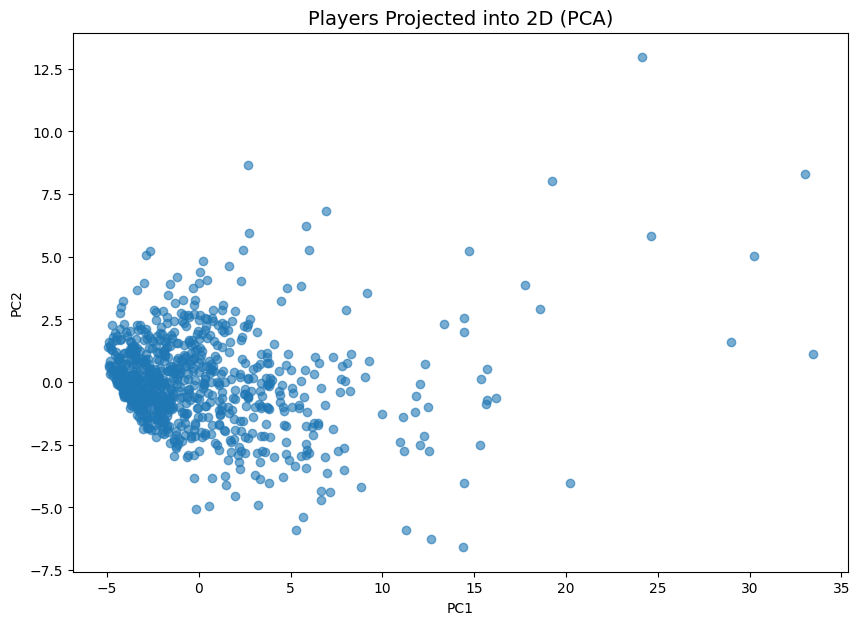

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use numeric stats as features (already scaled)
# X = nhl_defensemen[stats_cols].values

# Step 1: Combine numeric (scaled), categorical (one-hot), and maybe highlights
X_combined = hstack([X_stats_scaled, X_onehot, X_highlights])

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.title("Players Projected into 2D (PCA)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


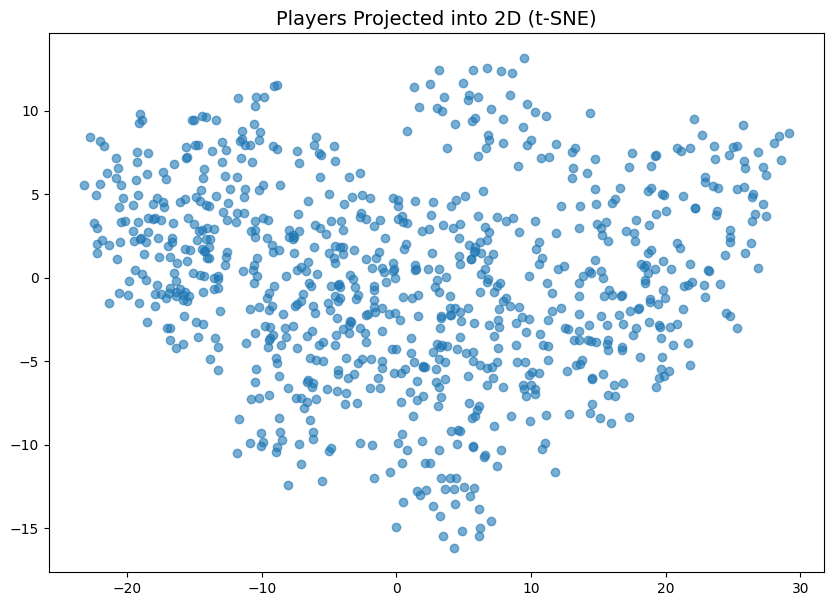

In [45]:
from sklearn.manifold import TSNE

# AgglomerativeClustering does not accept sparse matrices -> convert to dense
X_dense = X_combined.toarray()

X_tsne = TSNE(n_components=3, perplexity=30, random_state=42).fit_transform(X_dense)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6)
plt.title("Players Projected into 2D (t-SNE)", fontsize=14)
plt.show()


## Clustering

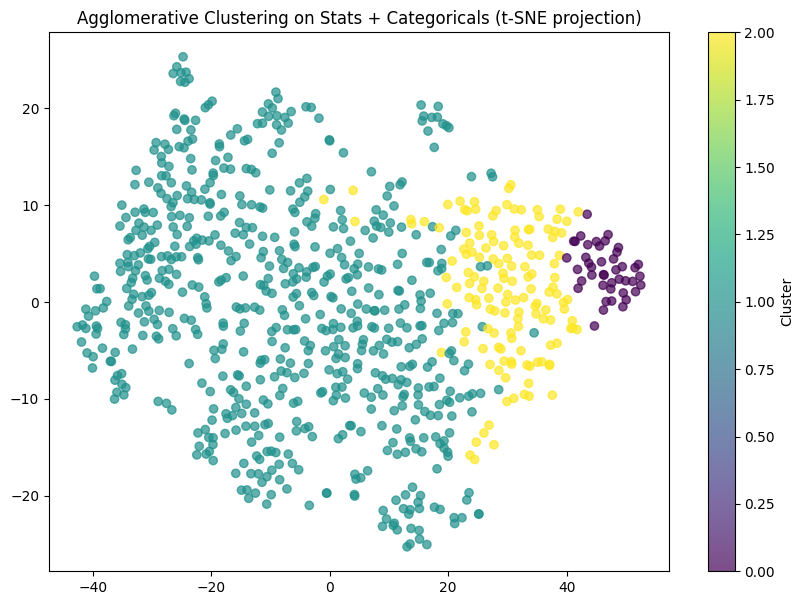

In [46]:
from scipy.sparse import hstack
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Combine numeric (scaled), categorical (one-hot), and maybe highlights
X_combined = hstack([X_stats_scaled, X_onehot, X_highlights])

# AgglomerativeClustering does not accept sparse matrices -> convert to dense
X_dense = X_combined.toarray()

# Step 2: Cluster in high-dimensional space
agg = AgglomerativeClustering(n_clusters=3)
labels = agg.fit_predict(X_dense)

# Add cluster labels back to DataFrame
nhl_defensemen['cluster'] = labels

# Step 3: Project to 2D with t-SNE for visualization
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_dense)

# Step 4: Plot
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Cluster')
plt.title("Agglomerative Clustering on Stats + Categoricals (t-SNE projection)")
plt.show()

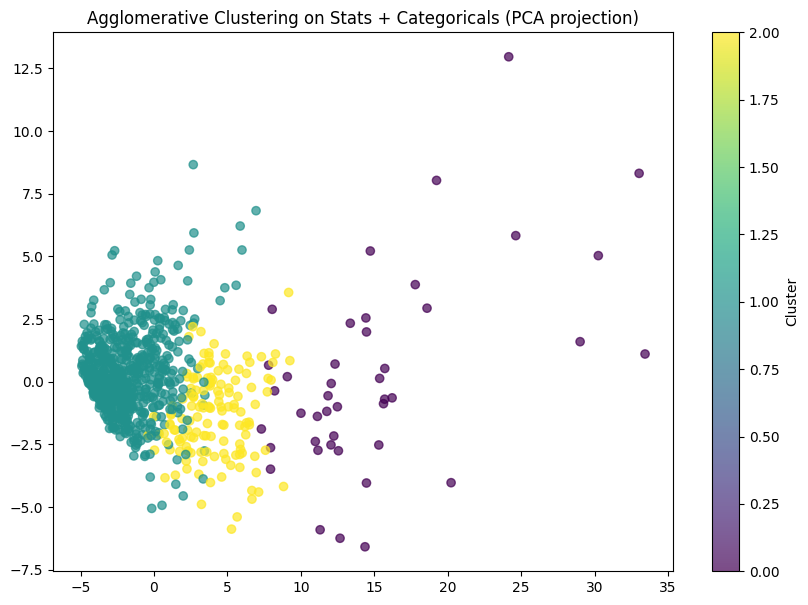

In [47]:
# Plot the clustering result using PCA
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Cluster')
plt.title("Agglomerative Clustering on Stats + Categoricals (PCA projection)")
plt.show()

In [48]:
# Show the datapoints which is in the orange cluster
orange_cluster = nhl_defensemen[labels == 0]
orange_cluster

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,draft_year,norris,calder,conn_smythe,hart,all_star_first,all_star_second,stanley_cup,hhof,cluster
0,6,Ray Bourque,22,22,1612,14,82,410,1169,1579,...,1979.0,5,1,0,0,15,6,1,1,0
6,18,Rob Blake,20,18,1270,4,84,240,537,777,...,1988.0,1,0,0,0,1,3,1,1,0
60,234,Cale Makar,6,6,395,44,80,116,312,428,...,2017.0,2,1,1,0,3,2,1,0,0
89,348,Phil Housley,21,21,1495,1,80,338,894,1232,...,1982.0,0,0,0,0,0,1,0,2,0
103,392,Duncan Keith,17,17,1256,47,82,106,540,646,...,2002.0,2,0,1,0,2,1,3,1,0
107,401,Dustin Byfuglien,14,14,869,9,82,177,348,525,...,2003.0,0,0,0,0,0,1,1,0,0
215,888,Al Macinnis,23,21,1416,2,82,340,934,1274,...,1981.0,1,0,1,0,6,3,1,1,0
216,889,Chris Pronger,18,17,1167,5,82,157,541,698,...,1993.0,1,0,0,1,3,3,1,1,0
241,986,Alex Pietrangelo,17,17,1087,8,81,148,489,637,...,2008.0,0,0,0,0,0,3,2,0,0
246,1006,Wade Redden,14,14,1023,6,82,109,348,457,...,1995.0,0,0,0,0,1,4,0,0,0


In [49]:
# Find Cale Makar
cale_makar = nhl_defensemen[nhl_defensemen['player_name_official'] == 'Cale Makar']
cale_makar["cluster"]

60    0
Name: cluster, dtype: int64

In [50]:
# Find Erik Karlsson
erik_karlsson = nhl_defensemen[nhl_defensemen['player_name_official'] == 'Erik Karlsson']
erik_karlsson["cluster"]

745    0
Name: cluster, dtype: int64

In [51]:
# Find Olli Maatta
olli_maatta = nhl_defensemen[nhl_defensemen['player_name_official'] == 'Olli Maatta']
olli_maatta["cluster"]

144    1
Name: cluster, dtype: int64

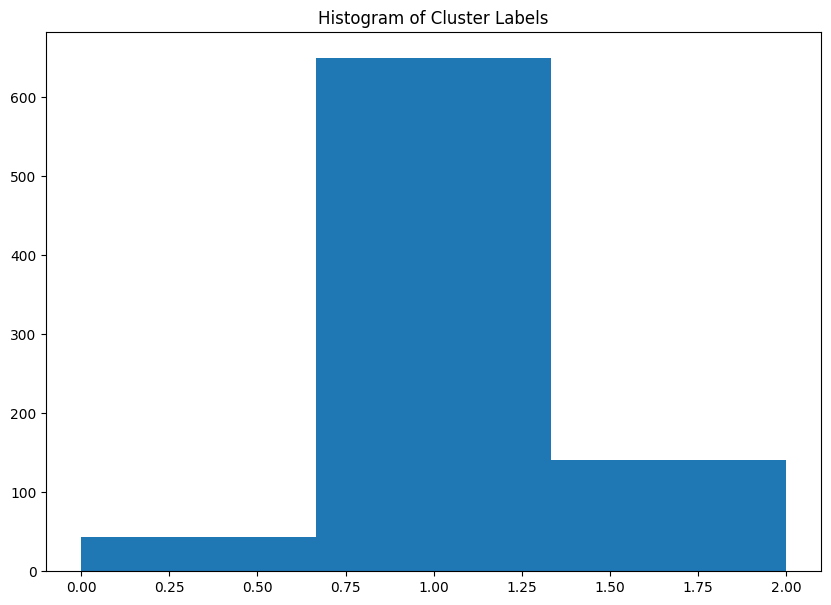

In [52]:
# Plot the histogram of the cluster labels
plt.figure(figsize=(10, 7))
plt.hist(labels, bins=3)
plt.title("Histogram of Cluster Labels")
plt.show()

In [55]:
# Assign Tiers
tiers = {
    0: 1, # tier 1
    2: 2, # tier 2
    1: 3, # tier 3
}

nhl_defensemen['tier'] = nhl_defensemen['cluster'].map(tiers)

# Drop Cluster
nhl_defensemen.drop(['cluster'], axis=1, inplace=True)

In [56]:
nhl_defensemen.head()

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,draft_year,norris,calder,conn_smythe,hart,all_star_first,all_star_second,stanley_cup,hhof,tier
0,6,Ray Bourque,22,22,1612,14,82,410,1169,1579,...,1979.0,5,1,0,0,15,6,1,1,1
1,9,Martin Skoula,10,10,776,17,82,44,152,196,...,1998.0,0,0,0,0,0,1,1,0,3
2,11,Greg De Vries,13,13,878,6,82,48,146,194,...,NaN,0,0,0,0,0,0,1,0,3
3,13,Jon Klemm,15,13,773,4,82,42,100,142,...,NaN,0,0,0,0,0,1,2,0,3
4,14,Adam Foote,19,19,1154,12,81,66,242,308,...,1989.0,0,0,0,0,1,0,2,0,3


In [57]:
# Write to CSV
nhl_defensemen.to_csv('../dataset/preprocess/nhl_defensemen_with_tiers.csv', index=False)

### Further Clustering the tier 3 players

Tier 3 defensemen count: 650
Feature dimensions: (650, 98)


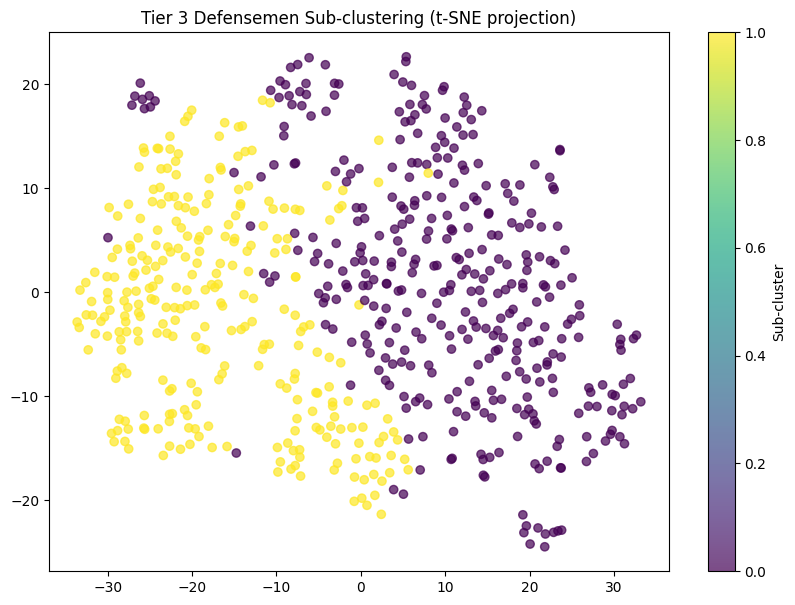

In [69]:
# Get tier 3 defensemen indices
tier_3_indices = nhl_defensemen[nhl_defensemen['tier'] == 3].index

# Extract the corresponding features from the already encoded data
X_tier_3 = X_dense[tier_3_indices]

print(f"Tier 3 defensemen count: {len(tier_3_indices)}")
print(f"Feature dimensions: {X_tier_3.shape}")

# Perform sub-clustering on tier 3 players
from sklearn.cluster import AgglomerativeClustering

# Use fewer clusters for the subset
agg_tier3 = AgglomerativeClustering(n_clusters=2, linkage='ward')
tier3_labels = agg_tier3.fit_predict(X_tier_3)

# Create sub-tiers (3a, 3b)
tier_3_defensemen = nhl_defensemen[nhl_defensemen['tier'] == 3].copy()
tier_3_defensemen['sub_tier'] = ['3a' if label == 0 else '3b' for label in tier3_labels]

# Visualize the sub-clustering
X_tier3_tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(tier_3_indices)//3)).fit_transform(X_tier_3)

plt.figure(figsize=(10, 7))
plt.scatter(X_tier3_tsne[:, 0], X_tier3_tsne[:, 1], c=tier3_labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Sub-cluster')
plt.title("Tier 3 Defensemen Sub-clustering (t-SNE projection)")
plt.show()

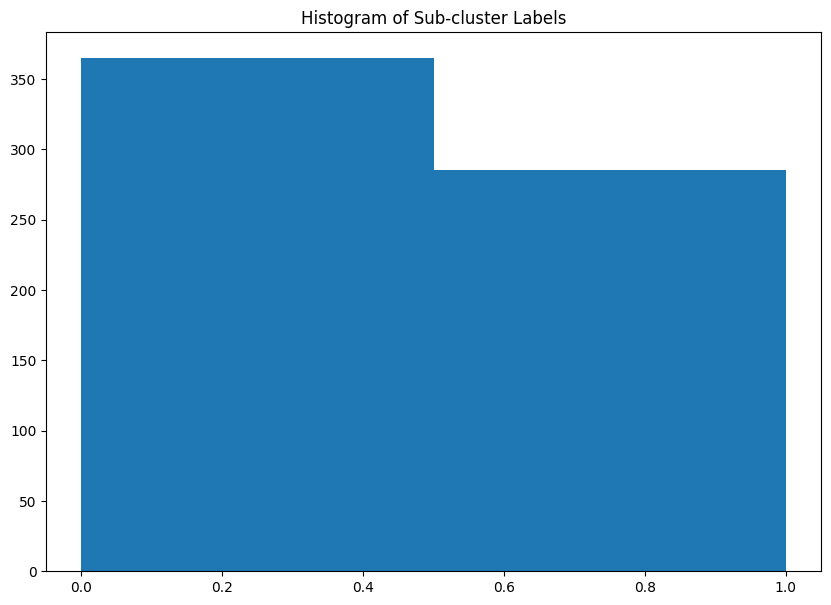

In [70]:
# Plot the histogram of the cluster labels
plt.figure(figsize=(10, 7))
plt.hist(tier3_labels, bins=2)
plt.title("Histogram of Sub-cluster Labels")
plt.show()

In [73]:
# Show the average g_regular_per_season of each sub_tier
tier_3_defensemen.groupby('sub_tier')['p_regular_per_season'].mean()

sub_tier
3a    13.564537
3b     6.269132
Name: p_regular_per_season, dtype: float64

In [74]:
# Change tier 3b to tier 4
tier_3_defensemen['tier'] = tier_3_defensemen['sub_tier'].apply(lambda x: 4 if x == '3b' else 3)

In [75]:
# Modified the tier in nhl_defensemen
nhl_defensemen.loc[tier_3_indices, 'tier'] = tier_3_defensemen['tier'].values

In [76]:
nhl_defensemen

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,draft_year,norris,calder,conn_smythe,hart,all_star_first,all_star_second,stanley_cup,hhof,tier
0,6,Ray Bourque,22,22,NaN,NaN,NaN,NaN,NaN,NaN,...,1979.0,5,1,0,0,15,6,1,1,1
1,9,Martin Skoula,10,10,776.0,17.0,82.0,44.0,152.0,196.0,...,1998.0,0,0,0,0,0,1,1,0,3
2,11,Greg De Vries,13,13,878.0,6.0,82.0,48.0,146.0,194.0,...,NaN,0,0,0,0,0,0,1,0,3
3,13,Jon Klemm,15,13,773.0,4.0,82.0,42.0,100.0,142.0,...,NaN,0,0,0,0,0,1,2,0,3
4,14,Adam Foote,19,19,1154.0,12.0,81.0,66.0,242.0,308.0,...,1989.0,0,0,0,0,1,0,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,3876,Adam Burt,13,12,737.0,5.0,78.0,37.0,115.0,152.0,...,1987.0,0,0,0,0,0,1,0,0,3
830,3878,David Harlock,8,4,212.0,1.0,70.0,2.0,14.0,16.0,...,1990.0,0,0,0,0,0,0,0,0,4
831,3889,Matt Jones,3,3,106.0,16.0,45.0,1.0,10.0,11.0,...,2002.0,0,0,0,0,0,0,0,0,4
832,3896,Boris Valabik,3,3,80.0,7.0,50.0,0.0,7.0,7.0,...,2004.0,0,0,0,0,0,0,0,0,4


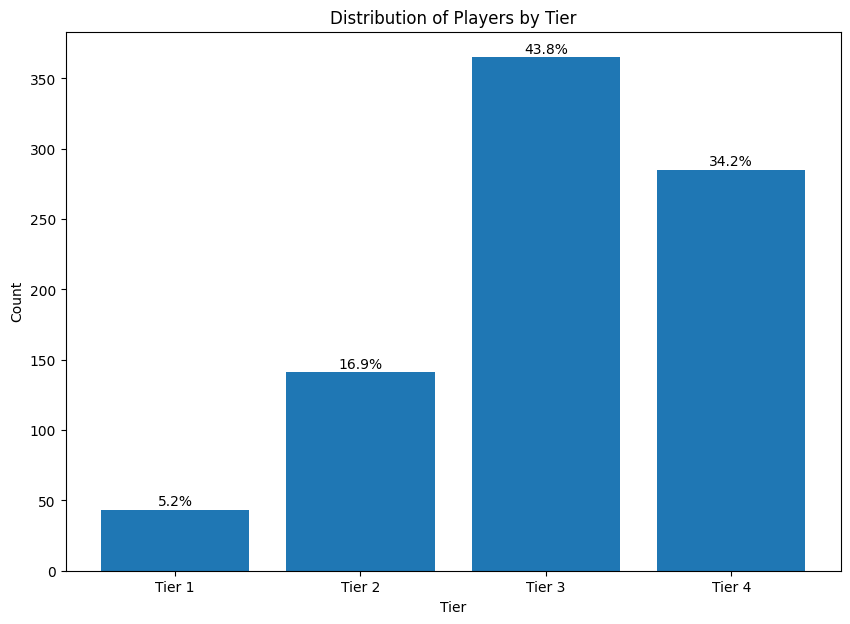

In [79]:
import matplotlib.pyplot as plt

# Calculate counts and percentages
tier_counts = nhl_defensemen['tier'].value_counts().sort_index()
tier_percentages = tier_counts / len(nhl_defensemen) * 100

# Plot bar chart instead of histogram
plt.figure(figsize=(10, 7))
bars = plt.bar(tier_counts.index, tier_counts.values, tick_label=[f"Tier {i}" for i in tier_counts.index])

# Annotate with percentages
for bar, pct in zip(bars, tier_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Players by Tier")
plt.xlabel("Tier")
plt.ylabel("Count")
plt.show()

In [80]:
# Show the average p_regular_per_season of each tier
nhl_defensemen.groupby('tier')['p_regular_per_season'].mean()

tier
1    43.798916
2    28.000273
3    13.564537
4     6.269132
Name: p_regular_per_season, dtype: float64